In [1]:
# !pip install -U scikit-learn

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datos_2c2020_tp2.models.log.Logger as logger

In [3]:
train = pd.read_csv("../datasets/xgb-train.csv")
test = pd.read_csv("../datasets/xgb-test.csv")

In [4]:
# train['Week_Day'].describe()

# TP2 - XGBoost Binary Classifier


Luego verifico que dropear filas que se overlapean con test implica
dejar de lado la mayoria de datos por lo cual no se tendraa en cuenta.
(djo el codigo de dropeo comentaado)

-----------------------------------------


# Seteo de features

In [5]:
target = "target"
features = list(train.columns)
features.remove(target)
features.remove("created_blocknum")
features.remove("Opportunity_ID")

#VANILLA NO
features.remove("delivery_delay")
features.remove("opportunity_lifetime")
features.remove("converted_taxable_amount")
features.remove("last_modified_to_delivery")
features.remove("currency_conversion_rate")
features.remove("Occur")
features.remove("delivery_window")
features.remove("account_creation_to_created_opp")

#VANILLA SI
# features.remove('Total_Taxable_Amount')
# features.remove('ASP_(converted)')
# features.remove("ASP")
# features.remove("Total_Amount")
# features.remove("Delivery_Year")
# features.remove("Week_Day")

#CONSIDERO REMOVIBLES
features.remove("late_delivery_blocknum")
features.remove("early_delivery_blocknum")
features.remove("last_modified_blocknum")
features.remove("account_creation_blocknum") #OJO CCON HIPOTESIS DEL CLIENTE VIEEJO
print("Features totales: {}".format(len(features)))



Features totales: 111


# Armado de sets
FORMAS:

In [6]:
X_train, y_train = train.loc[:,features], train.loc[:,target]
X_test_Opp = test.loc[:,"Opportunity_ID"]
X_test = test.loc[:,features]


print(X_train.shape)
print(X_test.shape)

(16947, 111)
(2551, 111)


In [7]:

dtrain = xgb.DMatrix(X_train, label=y_train)



# Tuneo de hiperparametros
* GRIDSEARCH + CROSS VALIDATION

Configuracion

In [8]:
params = {"objective": "binary:logistic",
          'colsample_bytree': 0.3,
          'subsample': 1.0,
          'learning_rate': 0.1,
          'max_depth': 8,
          'min_child_weight': 1,
          'eval_metric': 'logloss'}

nfolds = 7
rounds = 160
early_stopping_rounds = 10

enaable_gridsearch_for_tree = False
enaable_gridsearch_for_sampling = False
enaable_gridsearch_for_learning = False
final_cv = True

print("Usando nfolds={},  num_boost_round={}"
      "  y  early_stopping_rounds={}".format(nfolds, rounds, early_stopping_rounds))

Usando nfolds=7,  num_boost_round=160  y  early_stopping_rounds=10


TUNEO DE:
* max_depth
* min_child_weight

In [9]:
if enaable_gridsearch_for_tree:
    gridsearch_params = [
        (max_depth, min_child_weight)
        for max_depth in range(1,9)
        for min_child_weight in range(1,2)
    ]

    # Define initial best params and LogLoss
    min_logloss = float("Inf")
    best_params = None
    for max_depth, min_child_weight in gridsearch_params:
        print("CV with max_depth={}, min_child_weight={}".format(
                                 max_depth,
                                 min_child_weight))
        # Update our parameters
        params['max_depth'] = max_depth
        params['min_child_weight'] = min_child_weight
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=rounds,
            seed=151243,
            nfold=nfolds,
            metrics='logloss',
            early_stopping_rounds=early_stopping_rounds
        )
        # Update best LogLoss
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        print("\tLL {} for {} rounds".format(mean_logloss, boost_rounds+1))
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (max_depth,min_child_weight)
    print("Best max_depth,min_child_weight: {}, {}, LogLoss: {}".format(best_params[0], best_params[1], min_logloss))

    params['max_depth'] = best_params[0]
    params['min_child_weight'] = best_params[1]

TUNEO DE:
* subsamble
* colsample_bytree


In [10]:
if enaable_gridsearch_for_sampling:
    gridsearch_params = [
        (subsample, colsample_bytree)
        for subsample in [i/10. for i in range(8,11)]
        for colsample_bytree in  [i/10. for i in range(3,5)]
    ]

    # Define initial best params and LogLoss
    min_logloss = float("Inf")
    best_params = None
    for subsample, colsample_bytree in gridsearch_params:
        print("CV with subsample={}, colsample_bytree={}".format(
                                 subsample,
                                 colsample_bytree))
        # Update our parameters
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=rounds,
            seed=151243,
            nfold=nfolds,
            metrics='logloss',
            early_stopping_rounds=early_stopping_rounds
        )
        # Update best LogLoss
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        print("\tLL {} for {} rounds".format(mean_logloss, boost_rounds+1))
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_params = (subsample,colsample_bytree)
    print("Best subsample,colsample_bytree: {}, {}, LogLoss: {}".format(best_params[0], best_params[1], min_logloss))

    params['subsample'] = best_params[0]
    params['colsample_bytree'] = best_params[1]

TUNEO DE:
* learning rate (eta)

In [11]:
if enaable_gridsearch_for_learning:
    min_logloss = float("Inf")
    best_learning_rate = None
    for learning_rate in [0.2, 0.15, 0.1, 0.05]:
        print("CV with learning_rate={}".format(learning_rate))
        # Update our parameters
        params['learning_rate'] = learning_rate
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=rounds,
            seed=151243,
            nfold=nfolds,
            metrics='logloss',
            early_stopping_rounds=early_stopping_rounds
        )
        # Update best LogLoss
        mean_logloss = cv_results['test-logloss-mean'].min()
        boost_rounds = cv_results['test-logloss-mean'].argmin()
        print("\tLL {} for {} rounds".format(mean_logloss, boost_rounds+1))
        if mean_logloss < min_logloss:
            min_logloss = mean_logloss
            best_learning_rate = learning_rate
    print("Best learning_rate: {}, LogLoss: {}".format(best_learning_rate, min_logloss))

Final cross validation error

In [12]:
if final_cv:
    cv_results = xgb.cv(
                params,
                dtrain,
                num_boost_round=999,
                seed=151243,
                nfold=len(features),
                metrics='logloss',
                early_stopping_rounds=early_stopping_rounds
            )
    print("Rounds    LogLoss \n  {}.".format(cv_results["test-logloss-mean"].tail(1)))


Rounds    LogLoss 
  393    0.190963
Name: test-logloss-mean, dtype: float64.


# Entrenamiento

In [13]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic',
            colsample_bytree = params['colsample_bytree'],
            learning_rate = params['learning_rate'],
            max_depth = params['max_depth'],
            n_estimators = rounds,
            reg_alpha=0,
            min_child_weight = params['min_child_weight'])


xg_reg.fit(X_train,y_train)


[11:25:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\fedeb\desktop\datos\workspace\venv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=160, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
preds = [pred[0] for pred in xg_reg.predict_proba(X_test)]
# preds


Guardando las predicciones a CSV

In [15]:
pred_df = pd.DataFrame(X_test_Opp)
pred_df["Target"] = preds
pred_df = pred_df.drop_duplicates("Opportunity_ID")
pred_df
pred_df.to_csv("../submits/xgb-bc1.csv",index=False)

{'objective': 'binary:logistic', 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'eval_metric': 'logloss'}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

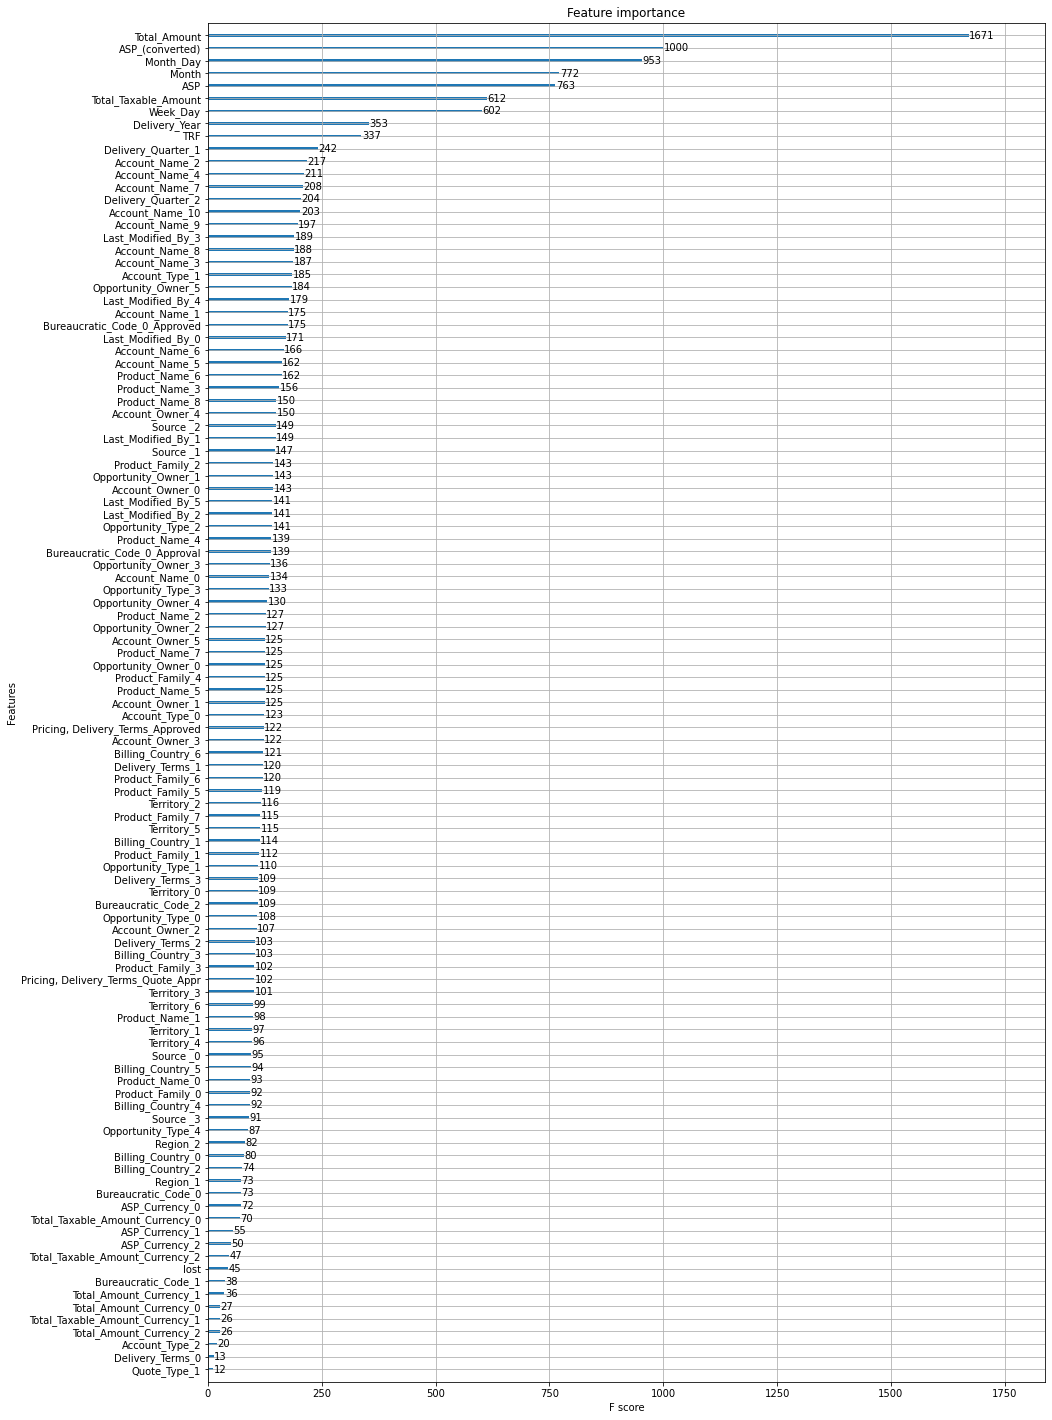

In [16]:
print(params)
plt.rcParams['figure.figsize'] = [15, 25]
xgb.plot_importance(xg_reg)


In [17]:
# logger.Logger.log_model("xgb-logloss", params, features, cv_score)